In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import time

In [4]:
df_digest_protein = pd.read_csv('../data/uniprot/df_digest_protein_noptm.csv')

In [5]:
print(df_digest_protein.shape)
df_digest_protein.head(1)

(3925, 5)


,PROTEIN,SEQUENCE,PROTEIN_FULL,SPECTRAL_CNT,SPECTRAL_CNT_MISS
0,sp|Q9NP61|ARFG3_HUMAN,MGDPSKQDILTIFKRLRSVPTNKVCFDCGAKNPSWASITYGVFLCI...,>sp|Q9NP61|ARFG3_HUMAN ADP-ribosylation factor...,M_1;G_8;D_0;P_5;S_0;K_0;Q_5;D_2;I_2;L_2;T_2;I_...,M_1;G_9;D_9;P_14;S_14;K_14;Q_17;D_17;I_17;L_17...


# Digestibility Modeling
  - labelling followed AP3 paper

In [6]:
def labelling_ap3(prot2cnt, prot2cnt_miss, THRESHOLD = 4):  # prot2cnt, prot2cnt_miss must be list split by ;

    ts2label = dict()
    # protein loop
    for idx in range(len(prot2cnt)):
        # amino acid loop in one protein
        for amino_idx in range(len(prot2cnt[idx])):
            # tryptic site : K, R
            if prot2cnt[idx][amino_idx][:1] in 'KR':
                
                # *******TRYPTIC SITE EXTRACTING FROM PROTEIN*******
                # tryptic site in protein N-terminal
                if amino_idx <= THRESHOLD - 1:
                    tryptic_site = 'Z'*(THRESHOLD-amino_idx) + ''.join([a[0] for a in prot2cnt[idx][: amino_idx+THRESHOLD + 1]])  # added Z
                # tryptic site in protein C-terminal
                elif amino_idx >= len(prot2cnt[idx]) - THRESHOLD:
                    tryptic_site = ''.join([a[0] for a in prot2cnt[idx][amino_idx-THRESHOLD: amino_idx+THRESHOLD + 1]]) + 'Z'*(THRESHOLD-(len(prot2cnt[idx])-1)+amino_idx)  # added Z
                else:
                    tryptic_site = ''.join([a[0] for a in prot2cnt[idx][amino_idx-THRESHOLD: amino_idx+THRESHOLD + 1]])

                    
                # *******TRYPTIC SITE LABELLING (WHEN POSITIVE)*******
                # N-terminal of tryptic site condition
                N_Pcondition = int(prot2cnt[idx][amino_idx][2:]) >= 1
                # C-terminal of tryptic site condition
                if amino_idx == len(prot2cnt[idx]) - 1:  # tryptic site in last position of protein
                    C_prot2cntondition = True
                else:
                    C_prot2cntondition = int(prot2cnt[idx][amino_idx + 1][2:]) >= 1
                # miss cleavage of tryptic site contidion
                miss_prot2cntondition = int(prot2cnt_miss[idx][amino_idx][2:]) == 0
                # True of all above, Positive labeling
                P_condition = (N_Pcondition == True) and (C_prot2cntondition == True) and (miss_prot2cntondition == True)

                # *******TRYPTIC SITE LABELLING (WHEN NEGATIVE)*******
                # N-terminal of tryptic site condition
                N_NCondition = int(prot2cnt[idx][amino_idx][2:]) == 0
                # C-terminal of tryptic site condition
                if amino_idx == len(prot2cnt[idx]) - 1:  # tryptic site in last position of protein
                    C_NCondition = False
                else:
                    C_NCondition = int(prot2cnt[idx][amino_idx + 1][2:]) == 0
                # miss cleavage of tryptic site condition
                miss_Ncondition = int(prot2cnt_miss[idx][amino_idx][2:]) >= 1
                # True of all above, Negative labeling
                N_condition = (N_NCondition == True) and (C_NCondition == True) and (miss_Ncondition == True)

                # *******MAKING DATASET*******
                if P_condition:
                    if tryptic_site not in ts2label:
                        ts2label[tryptic_site] = []
                    ts2label[tryptic_site].append(('P', idx, amino_idx))
                elif N_condition:
                    if tryptic_site not in ts2label:
                        ts2label[tryptic_site] = []
                    ts2label[tryptic_site].append(('N', idx, amino_idx))
    
    # *******JUST FOR COUNTING*******
    p = [k for k, v in ts2label.items() if v[0][0]=='P']
    n = [k for k, v in ts2label.items() if v[0][0]=='N']
    print(' P, unique p: {} \n n, unique n: {} \n total : {:,}'.format(
         (len(p), len(set(p))), 
         (len(n), len(set(n))), 
         len(p)+len(n)))
    df = pd.DataFrame({'tryptic_site':p+n, 'label':['P' if i in p else 'N' for i in p+n]})
    return df, ts2label

In [7]:
prot2cnt = [_.split(';') for _ in df_digest_protein.SPECTRAL_CNT.values]
prot2cnt_miss = [_.split(';') for _ in df_digest_protein.SPECTRAL_CNT_MISS.values]

In [8]:
df_digest, ts2label = labelling_ap3(prot2cnt, prot2cnt_miss, THRESHOLD=4)  # ts2label is just for checking

 P, unique p: (21382, 21382) 
 n, unique n: (9076, 9076) 
 total : 30,458


* train digestibility model

In [9]:
def onehot_enc(aa):
    return [1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ']

In [10]:
X = np.array([[__ for _ in ts for __ in onehot_enc(_)] for ts in df_digest.tryptic_site.values])
y = df_digest.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, random_state=77)
print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)
RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_digest.fit(X_train, y_train)

(30458, 189) (30458,) (22843, 189) (7615, 189) (22843,) (7615,)


RandomForestClassifier(max_features='sqrt', n_estimators=200)

In [11]:
y_pred = RF_digest.predict(X_test)
print(classification_report(y_test, y_pred))
probs = RF_digest.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, probs)
print('AUC : {}'.format(rf_auc))

              precision    recall  f1-score   support

           N       0.86      0.66      0.75      2241
           P       0.87      0.96      0.91      5374

    accuracy                           0.87      7615
   macro avg       0.87      0.81      0.83      7615
weighted avg       0.87      0.87      0.87      7615

AUC : 0.915291443240605


In [12]:
RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_digest.fit(X, y)  # for adjusting Detectability

RandomForestClassifier(max_features='sqrt', n_estimators=200)

# Detectability

In [13]:
def cal_digestibility(seq_li, model):
    noseq_idx = [idx for idx, _ in enumerate(seq_li) if _ == '-']
    X = np.array([[__ for _ in seq for __ in onehot_enc(_)] if seq != '-' else [0]*189 for seq in seq_li])
    y_pred = model.predict_proba(X)[:, 1]  # positive probability = digestibility
    y_pred[noseq_idx] = 1
    return y_pred

In [14]:
def labelling_detect(df, aa2val, RF_digest):
    df_ = df.copy()
    # set tryptic site 9mer
    df_['miss'] = [sum([1 for _ in p[:-1] if _ in 'KR']) for p in df_.PEP.values]
    df_['En'] = df_.En.apply(lambda x: x[3:-3]).values
    df_['Ec'] = df_.Ec.apply(lambda x: x[3:-3]).values
    df_['E1'] = df_.E1.apply(lambda x: x[3:-3] if x != '-' else '-').values
    df_['E2'] = df_.E2.apply(lambda x: x[3:-3] if x != '-' else '-').values

    # digestibility
    score_n = cal_digestibility(df_.En.values, RF_digest)
    score_c = cal_digestibility(df_.Ec.values, RF_digest)
    score_m1 = cal_digestibility(df_.E1.values, RF_digest)
    score_m2 = cal_digestibility(df_.E2.values, RF_digest)
    df_['digestibility'] = score_n * score_c * score_m1 * score_m2
    
    # get AA index
    cols = list(range(21+len(aa2val['A'])))  # aa_cnt + aa_index length sum 
    cols_value = []
    for seq in df_.PEP.values:
        aa_cnt = [seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYVZ']
        aa_index = list(np.array([aa2val[aa] for aa in seq]).sum(axis=0))
        cols_value.append(aa_cnt+aa_index)
    df_[cols] = cols_value

    df_.drop(['peptide', 'En', 'Ec', 'E1', 'E2', 'protein', 'PEP'], axis=1, inplace=True)
    return df_

In [15]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm.csv')
df_detect_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm.csv')

# AA index
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex.csv')
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

* mRMR top 50 features selection
  - https://github.com/smazzanti/mrmr

In [16]:
train = labelling_detect(df_detect_peptide_train, aa2val, RF_digest)

In [17]:
from mrmr import mrmr_classif

X = train.drop('ID', axis=1)
y = train.ID

# use mrmr classification
selected_features = mrmr_classif(X, y, K = 50)

100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


* Forward Selection strategy with 10 cross validation
  - in paper, 29 feature is optimal

In [18]:
start = time.time()

col2auc = dict()
for col_idx in range(1, len(selected_features)+1):
    print(col_idx, round(time.time() - start, 2), end='\r')
    
    cols = selected_features[:col_idx] + ['ID']
    df_selection = train[cols]
    X = df_selection.drop('ID', axis=1).values
    y = df_selection.ID.values
    clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', random_state=7)
    scores = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
    col2auc[col_idx] = sum(scores) / len(scores)

In [19]:
for i in sorted(col2auc.items(), key=lambda x:x[1], reverse=True):
    print(i)  # select 29 features

(46, 0.8748854413053925)
(48, 0.8748112937787657)
(47, 0.8741964398680446)
(45, 0.8740932014900876)
(49, 0.8739285378445393)
(50, 0.873768906411388)
(40, 0.8735282454078123)
(41, 0.8735110863244533)
(44, 0.8730396806807684)
(43, 0.8730289685522727)
(42, 0.8730208020174054)
(39, 0.8729914720559508)
(33, 0.8729076952433609)
(34, 0.8725597960909773)
(36, 0.872405338693448)
(35, 0.8723145504189274)
(31, 0.8722834758181477)
(30, 0.8722527820966846)
(32, 0.8719566411545261)
(37, 0.8718766608544707)
(38, 0.8718560801963168)
(29, 0.8716318080329012)
(27, 0.8713991727409122)
(26, 0.8713150177549188)
(25, 0.8711964891330721)
(28, 0.8709208882581937)
(24, 0.8707762882375588)
(23, 0.8704231849224178)
(22, 0.8703608306070676)
(21, 0.8703388197492743)
(20, 0.8698765523595704)
(19, 0.8694390853825789)
(18, 0.867158792259778)
(17, 0.8671365790428045)
(16, 0.8650377119120259)
(15, 0.8622609750558123)
(11, 0.8596177017954286)
(14, 0.8584657041653253)
(10, 0.8584111257578412)
(13, 0.8574181907337151)
(12

* final training

In [20]:
df = pd.concat([df_detect_peptide_train, df_detect_peptide_test], axis=0)
train_idx = df_detect_peptide_train.shape[0]

df_ = labelling_detect(df, aa2val, RF_digest)

In [21]:
train_final = df_.iloc[:train_idx]
test_final = df_.iloc[train_idx:]

In [22]:
cols = selected_features[:29] + ['ID']
train = train_final[cols]
test = test_final[cols]

In [23]:
X_train = train_final.drop('ID', axis=1).values
y_train = train_final.ID.values
X_test = test_final.drop('ID', axis=1).values
y_test = test_final.ID.values
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(177997, 574) (44499, 574) (177997,) (44499,)


In [24]:
RF_detect = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_detect.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=200)

              precision    recall  f1-score   support

           0       0.84      0.81      0.82     22330
           1       0.81      0.84      0.83     22169

    accuracy                           0.83     44499
   macro avg       0.83      0.83      0.83     44499
weighted avg       0.83      0.83      0.83     44499

rf auc : 0.9071393876825817


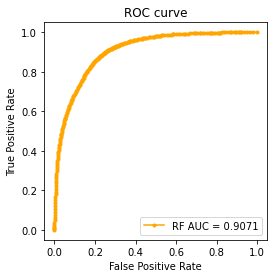

In [25]:
# prediction
y_pred = RF_detect.predict(X_test)
print(classification_report(y_test, y_pred))

# AUC
probs = RF_detect.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()